# 猫狗大战

## 准备工作

导入所需的库

In [114]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from tqdm import tqdm

from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

## 数据观察与预处理

先列出训练数据集`train`文件夹下的所有文件名。

In [2]:
train_dir = './train/'
files = []
for dirpath, dirname, filename in os.walk(train_dir):
    files.extend(filename)

### 随机抽取部分样本进行观察。

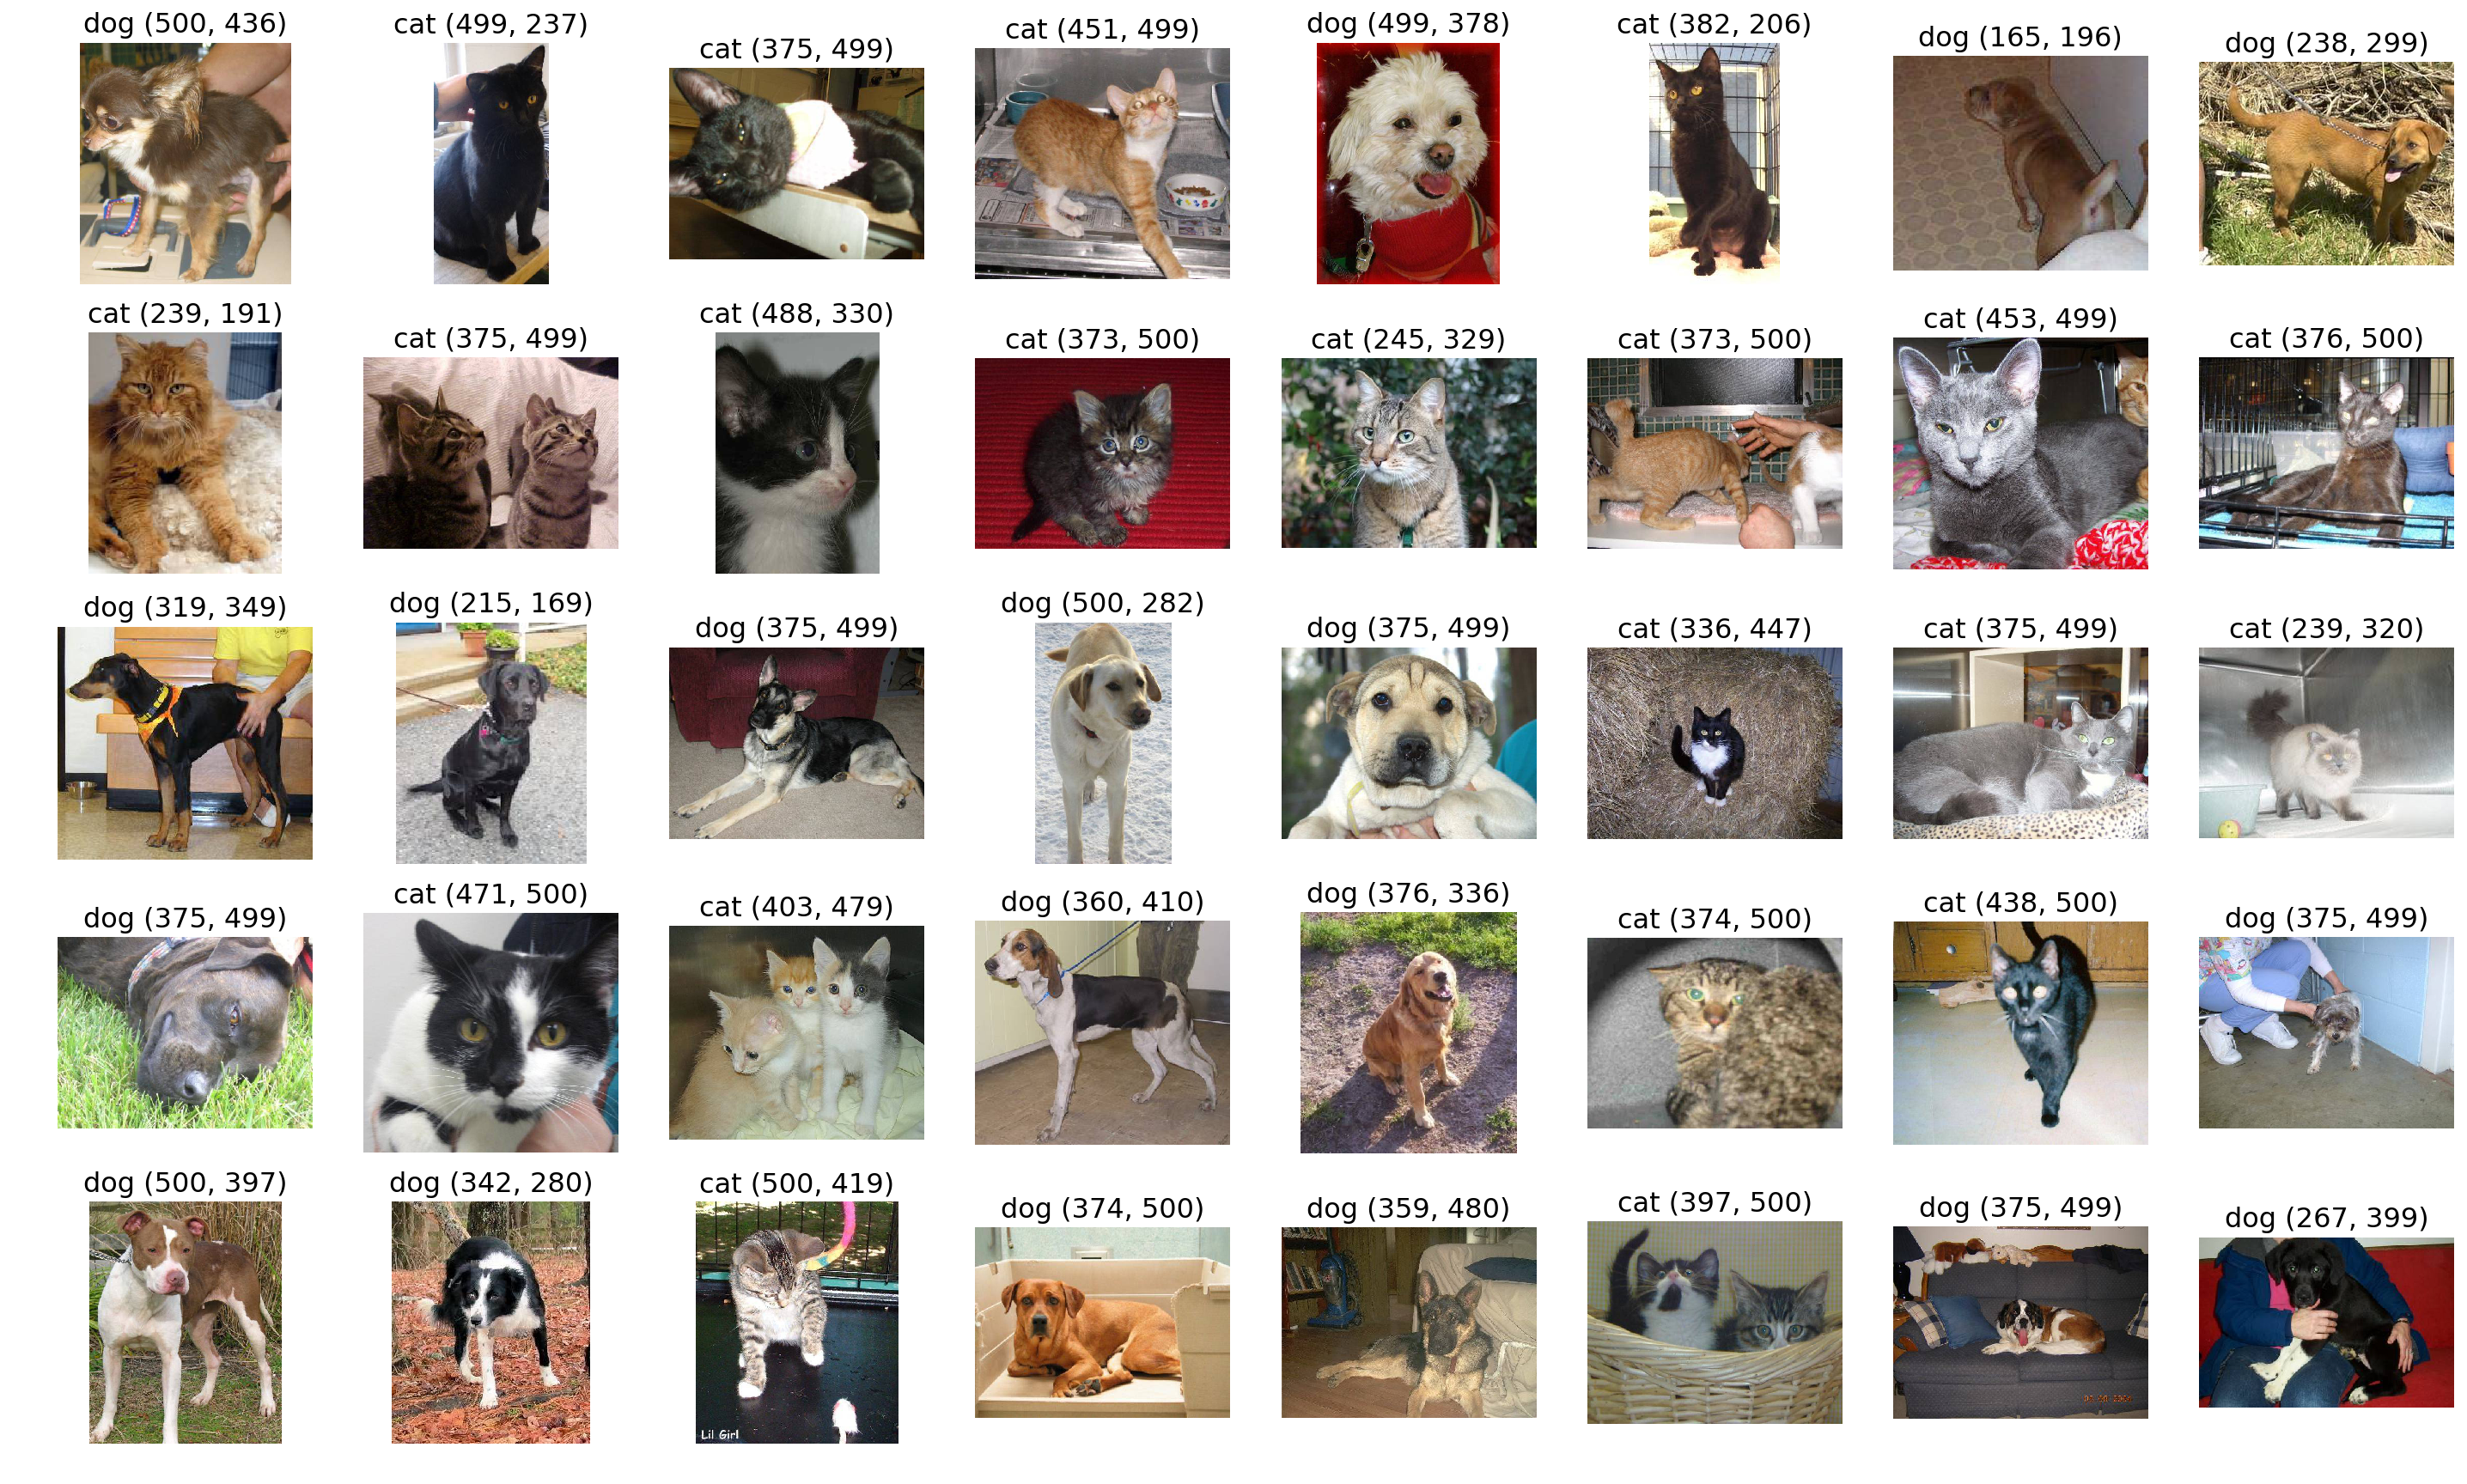

In [3]:
plt.figure(figsize=[25, 15])
random.seed(1234)
sample_size = 40
samples = random.sample(files, sample_size)
labels = [x.split('.')[0] for x in samples]
for i in range(1, sample_size+1):
    plt.subplot(5, 8, i)
    tester = mpimg.imread(train_dir+samples[i-1])
    img_shape = tester.shape[:2]
    plt.imshow(tester)
    plt.axis('off')
    plt.title(labels[i-1]+' '+str(img_shape), fontdict={'fontsize':16})
plt.savefig('samples.jpg')    
plt.show()

### 用预训练模型初始预测，找出那些非猫非狗的图片

先整理Imagenet1000的标签中，属于狗和猫的编号。整理工作来自优达前辈：https://zhuanlan.zhihu.com/p/34068451

In [10]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079' ,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364' ,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721' ,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339' ,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258' ,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437' ,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105' ,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236' ,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177' ,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251' ,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550' ,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089' ,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185' ,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889' ,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712' ,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597' ,'n02124075','n02125311','n02127052']
print(len(dogs))
print(len(cats))

118
7


开始预测并判断前三是否落在猫或狗的分类内。试试用三个不同的模型来预测。

第一是ResNet50:

In [99]:
resnet50 = ResNet50(weights='imagenet')

In [100]:
pred_in_resnet50 = []
for file in tqdm(files):
    img = image.load_img(train_dir+file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = resnet50.predict(x)
    labels = decode_predictions(preds, top = 30)[0]
    labs = list(list(zip(*labels))[0])
    lab_check = any([(l in dogs) or (l in cats) for l in labs])
    pred_in_resnet50.append(lab_check)

100%|██████████| 25000/25000 [39:17<00:00, 10.60it/s]


In [103]:
ex_idx_resnet50 = [x[0] for x in list(enumerate(pred_in)) if x[1] == False]
ex_files_resnet50 = [files[i] for i in ex_idx]
len(ex_files_resnet50)

13

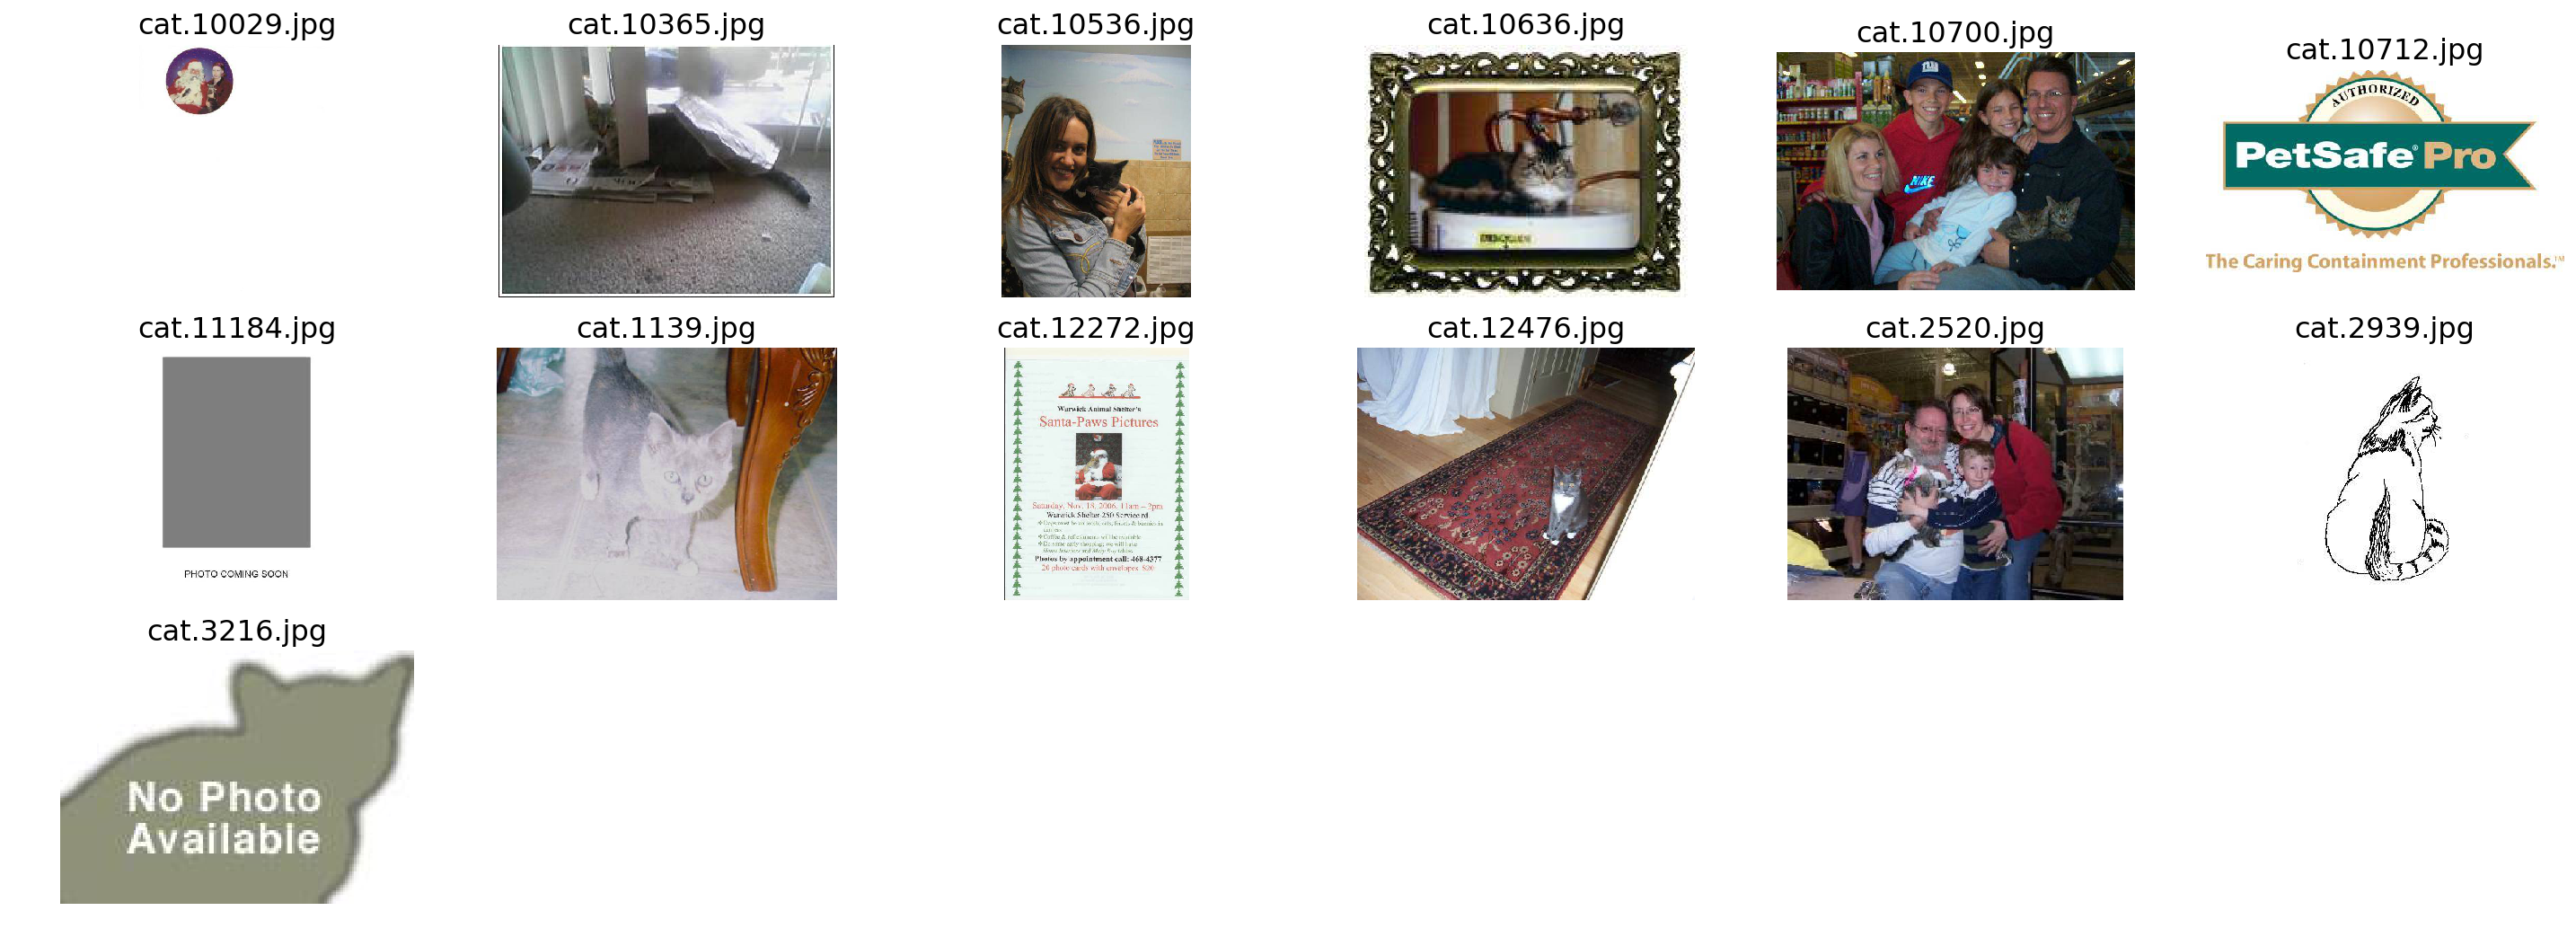

In [104]:
plt.figure(figsize=[25, 15])
for i in range(1, 1+13):
    plt.subplot(5, 6, i)
    tester = mpimg.imread(train_dir+ex_files_resnet50[i-1])
    plt.imshow(tester)
    plt.axis('off')
    plt.title(ex_files_resnet50[i-1], fontdict={'fontsize':16})
plt.savefig('ex_files_resnet50.jpg')
plt.show()

第二用Xception:

In [175]:
xception = Xception(weights='imagenet')

Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1051)

In [ ]:
pred_in_xception = []
test_smpl = files[:1000]
for file in tqdm(test_smpl):
    img = image.load_img(train_dir+file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = xception.predict(x)
    labels = decode_predictions(preds, top = 30)[0]
    labs = list(list(zip(*labels))[0])
    lab_check = any([(l in dogs) or (l in cats) for l in labs])
    pred_in_xception.append(lab_check)

In [ ]:
ex_idx_xception = [x[0] for x in list(enumerate(pred_in)) if x[1] == False]
ex_files_xception = [files[i] for i in ex_idx]
len(ex_files_xception)

In [ ]:
plt.figure(figsize=[25, 15])
for i in range(1, 1+13):
    plt.subplot(5, 6, i)
    tester = mpimg.imread(train_dir+ex_files_xception[i-1])
    plt.imshow(tester)
    plt.axis('off')
    plt.title(ex_files_xception[i-1], fontdict={'fontsize':16})
plt.savefig('ex_files_xception.jpg')
plt.show()

In [173]:
class Excluder:
    def __init__(self, model):
        depatcher = {'ResNet50': ResNet50, 'Xception': Xception, 'InceptionV3': InceptionV3}
        try:
            self.model = depatcher[model]()
            self.model_name = model
        except KeyError:
            print('invalid model. try {}'.format(depatcher.keys))
        self.excluder = self.model(weights = 'imagenet')
#         self.model_name = 
    def predict(self, files, smpl_size, path, target_size, top):
        test_smpl = files[:smpl_size]
        labels = []
        for file in tqdm(test_smpl):
            img = image.load_img(path+file, target_size)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            preds = self.excluder.predict(x)
            labels = labels.append(decode_predictions(preds, top = top)[0])
        return labels

In [174]:
resnet50 = Excluder(model='ResNet50')

TypeError: __call__() missing 1 required positional argument: 'inputs'

In [170]:
resnet50.predict(files, 100, train_dir, target_size=(224, 224), top=3)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Error when checking input: expected input_21 to have shape (224, 224, 3) but got array with shape (374, 500, 3)

In [171]:
resnet50.model()

<function keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>

In [172]:
model()

__main__.Excluder